# FYP - IllustrisTNG Lens Modelling

Lens Infomation:

No subhalos 

No shear - but still need to try shear

1st - Get the Position and position uncertainty 

Run positon constraint models

lambda CDM Cosmology

SIE 
NFW
POW
CORE SIE
EINASTO



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from error_propagation import Complex
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, IterativePSFPhotometry
from photutils.psf import make_psf_model_image, CircularGaussianPSF, GaussianPSF, MoffatPSF
from tqdm import tqdm
import emcee
norm = ImageNormalize(stretch=SqrtStretch())

# Initial Processing

In [58]:
image_file = "oldfiles/Rommulus_Mock_i2_SNIa_z1_cusp.fits"
# image_file = "Rommulus_withLight_Mock_i2_SNIa_z1_cusp.fits"

In [ ]:
hdu_list = fits.open(image_file)
hdu_list.info()

In [ ]:
hdu_list[0].header

In [ ]:
exposure = hdu_list[0].header['EXPT']
flux_density = hdu_list[0].header['PHOTFLAM']
flux_wavelength = hdu_list[0].header['WL_PIVOT']
pix_size = hdu_list[0].header['PIXSIZE']
z_l = hdu_list[0].header['Z_LENS']
z_s = hdu_list[0].header['Z_SOURCE']
gain = hdu_list[0].header['GAIN']
rdnoise = hdu_list[0].header['READNSE']
print('Exposure:', exposure)
print('Flux Density:', flux_density)
print('Flux Wavelength:', flux_wavelength)
print('Pixel Size:', pix_size)
print('Lens Redshift:', z_l)
print('Source Redshift:', z_s)
print('Gain:', gain)
print('Read Noise:', rdnoise)

In [66]:
image_data = hdu_list[0].data

In [ ]:
print(type(image_data))
print(image_data.shape)

In [68]:
hdu_list.close()

In [ ]:
# Plotting the original image
plt.figure(figsize=(10,8))
plt.imshow(image_data, cmap='inferno', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Original Image')
plt.colorbar(label='Electron/s')
plt.xlim(0, 125)
plt.ylim(0, 125)

In [72]:
df = pd.DataFrame(columns=['x', 'y', 'counts'])

In [73]:
# Convert to dataframe (more usable)
df['counts'] = image_data.flatten()
df['x'] = np.tile(np.arange(0, image_data.shape[0]), image_data.shape[1]) + 1
df['y'] = np.repeat(np.arange(0, image_data.shape[1]), image_data.shape[0]) + 1

In [ ]:
df

In [75]:
df['counts'] = df['counts'] * exposure

In [ ]:
# Original image as scatter plot 
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(10,8))
plt.scatter(df['x'], df['y'], c=df['counts'], cmap='inferno', s=25, marker='s', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.colorbar(label='Counts')
plt.title('Original Image')


In [ ]:
# Add an ellipse to the first subplot
ellipse1 = Ellipse((59.8, 72.2751), width=15, height=8, angle=20, edgecolor='red', facecolor='none', linewidth=1.5, linestyle='--', label='MCMC Source Offset')
plt.rc('font', family='Times New Roman')

# Original image as scatter plot 
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.scatter(df['x'], df['y'], c=df['counts'], cmap='inferno', s=100, marker='s', norm=norm)
plt.scatter(55.271, 70.5751, s=50, marker='x', color='r', label='MCMC Source')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.colorbar(label='Counts')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(df['x'], df['y'], c=df['counts'], cmap='inferno', s=100, marker='s', norm=norm)
plt.scatter(55.271, 70.5751, s=150, marker='x', color='r', label='MCMC Source')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.xlim(30, 95)
plt.ylim(30, 95)
plt.colorbar(label='Counts')
plt.gca().add_artist(ellipse1)
plt.legend()
plt.suptitle('MCMC Fit Position with Source Offset', font = 'Times New Roman', fontsize=16)


In [ ]:
# Mean + Std of counts for threshold calculation
mean_counts = np.mean(df['counts'].astype(float))
std_counts = np.std(df['counts'])
print('Mean Counts:', mean_counts)
print('Std Counts:', std_counts)

In [52]:
# Signal Detection (3 sigma threshold)
threshold = mean_counts + 3 * std_counts

df['detection'] = df['counts'] > threshold

In [ ]:
df

In [54]:
mask = pd.DataFrame(columns=['x', 'y', 'counts', 'detection'])

In [55]:
# Mask for detected pixels
for i in range(len(df)):
    if df['detection'][i] == True:
        new_row = pd.DataFrame({'x': [df['x'][i]], 'y': [df['y'][i]], 'counts': [df['counts'][i]], 'detection': [df['detection'][i]]})  # Create a new row as a DataFrame with index
        mask = pd.concat([mask, new_row], ignore_index=True)  # Concatenate the new row
        

In [ ]:
mask

In [ ]:
# Plotting only detected signals
plt.figure(figsize=(10,8))
plt.scatter(mask['x'], mask['y'], c=mask['counts'], cmap='inferno', s=25, marker='s', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.colorbar(label='Counts')
plt.title('Detected Signals')

In [63]:
# Initialize image column for counting number of images
mask['image'] = pd.DataFrame(np.zeros(len(mask)))

In [64]:
# Image detection / No of Images 
coordinates = list(zip(mask['x'], mask['y']))
visited = set()  
current_image = 1 

def find_images(x, y, image_no):
    stack = [(x, y)]
    while stack:
        cx, cy = stack.pop()
        if (cx, cy) in visited:
            continue
        visited.add((cx, cy))
    
        mask.loc[(mask['x'] == cx) & (mask['y'] == cy), 'image'] = image_no
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1), (-1, 1), (1, -1)]:
            nx, ny = cx + dx, cy + dy
            if (nx, ny) in coordinates and (nx, ny) not in visited:
                stack.append((nx, ny))

for x, y in coordinates:
    if (x, y) not in visited:
        find_images(x, y, current_image)
        current_image += 1 

In [ ]:
mask

In [ ]:
# Plot with images labelled
plt.figure(figsize=(10, 8))
scatter = plt.scatter(mask['x'], mask['y'], c=mask['counts'], cmap='inferno', s=25, marker='s', norm=norm)
plt.colorbar(scatter, label='Counts')

for image_id in mask['image'].unique():
    # Centroid for labelling 
    images = mask[mask['image'] == image_id]
    centroid_x = images['x'].mean()
    centroid_y = images['y'].mean() - 5
    plt.text(centroid_x, centroid_y, f'Image {int(image_id)}', fontsize=9, color='k', ha='center', va='center')

plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Detected Signals with Image Labels')
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.show()


In [67]:
# Counts to flux conversion
df['flux'] = (df['counts'] * flux_density * flux_wavelength) / exposure

In [ ]:
df

# Fitting the PSF

In [69]:
# Fitting the PSF 

# Backgorund estimation and subtraction (Done since PSFPhotomtery requires background subtraction)
# Procedure from https://photutils.readthedocs.io/en/stable/background.html#background

from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma=3.0, maxiters=20)
threshold = detect_threshold(image_data, nsigma=2.0, sigma_clip=sigma_clip)
segment_img = detect_sources(image_data, threshold, npixels=5)
footprint = circular_footprint(radius=5)
mask = segment_img.make_source_mask(footprint=footprint)
bkg_estimator = MedianBackground()
bkg = Background2D(image_data, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator, mask=mask)

In [ ]:
# Plotting the sky background
plt.figure(figsize=(10, 8))
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',interpolation='nearest')
plt.colorbar(label='Background')
plt.title('Background Noise Map')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.show()

In [ ]:
# Background subtracted image
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_data,cmap='inferno', origin='lower', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.colorbar(label='Electron/s')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(image_data - bkg.background, norm=norm, origin='lower',cmap='inferno')
plt.colorbar(label='Electron/s')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Background Subtracted Image')
plt.show()

In [72]:
# Subtracting the background
image_data = image_data - bkg.background

In [ ]:
# Moffat PSF fitting
psf_model = MoffatPSF(flux=2, alpha=2.5, beta=5.5)
fit_shape = (5, 5)
finder = DAOStarFinder(1.0, 4.0)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,aperture_radius=5)
phot = psfphot(image_data)
phot['x_fit'].info.format = '.4f'  # optional format
phot['y_fit'].info.format = '.4f'
phot['flux_fit'].info.format = '.4f'
print("Number of Images:", len(phot))
print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')]) 
resid = psfphot.make_residual_image(image_data, (9, 9))
from astropy.visualization import simple_norm
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
norm = simple_norm(image_data, 'sqrt', percent=99)
ax[0].imshow(image_data, origin='lower', norm=norm, cmap='magma')
ax[1].imshow(image_data - resid, origin='lower', norm=norm, cmap='magma')
im = ax[2].imshow(resid, origin='lower', cmap='magma')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].set_xlabel('x [px]')
ax[1].set_ylabel('y [px]')
ax[2].set_xlabel('x [px]')
ax[2].set_ylabel('y [px]')
ax[0].set_title('Data')
ax[1].set_title('Model')
ax[2].set_title('Residual Image')
plt.suptitle('Moffat PSF Fit', y=0.67)
plt.tight_layout()


In [74]:
# # Moffat Grid Search 
# flux = np.arange(1, 10, 1)
# alpha = np.arange(1, 5, 0.5)
# beta = np.arange(1, 5, 0.5)
# fwhm = np.arange(1, 5, 0.5)
# threshold = np.arange(1, 5, 0.5)
# param_permutations = [(f, a, b, w, t) for f in flux for a in alpha for b in beta for w in fwhm for t in threshold]
# results = pd.DataFrame(columns=['flux', 'alpha', 'beta', 'fwhm', 'threshold', 'std_resid'])

# for f, a, b, w, t in tqdm(param_permutations, desc='Grid Search', total=len(param_permutations)):
#     psf_model = MoffatPSF(flux=f, alpha=a, beta=b)
#     fit_shape = (5, 5)
#     finder = DAOStarFinder(fwhm=w, threshold=t)
#     psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,aperture_radius=5)
#     if psfphot(image_data) is None:
#         continue
#     resid = psfphot.make_residual_image(image_data, (9, 9))
#     std_resid = np.std(resid)
#     new_row = pd.DataFrame({'flux': [f], 'alpha': [a], 'beta': [b], 'fwhm': [w], 'threshold': [t], 'std_resid': [std_resid]})
#     results = pd.concat([results, new_row], ignore_index=True)

# best_params = results.loc[results['std_resid'].idxmin()]
# print('Best Parameters:', best_params)


In [ ]:
# Circular Gaussian PSF fitting
psf_model = CircularGaussianPSF(flux=1,fwhm=2.0)
fit_shape = (5, 5)
finder = DAOStarFinder(1.0, 4.0)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,aperture_radius=5)
phot = psfphot(image_data)
phot['x_fit'].info.format = '.4f'  # optional format
phot['y_fit'].info.format = '.4f'
phot['flux_fit'].info.format = '.4f'
print("Number of Images:", len(phot))
print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')]) 
resid = psfphot.make_residual_image(image_data, (9, 9))
from astropy.visualization import simple_norm
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
norm = simple_norm(image_data, 'sqrt', percent=99)
ax[0].imshow(image_data, origin='lower', norm=norm, cmap='magma')
ax[1].imshow(image_data - resid, origin='lower', norm=norm, cmap='magma')
im = ax[2].imshow(resid, origin='lower', cmap='magma')
ax[0].set_title('Data')
ax[1].set_title('Model')
ax[2].set_title('Residual Image')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].set_xlabel('x [px]')
ax[1].set_ylabel('y [px]')
ax[2].set_xlabel('x [px]')
ax[2].set_ylabel('y [px]')
plt.suptitle('Circular Gaussian PSF Fit', y=0.67)
plt.tight_layout()

In [ ]:
# Gaussian PSF fitting
psf_model = GaussianPSF(flux=1, x_fwhm=2.0, y_fwhm=2.0)
fit_shape = (5, 5)
finder = DAOStarFinder(1.0, 4.5)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,aperture_radius=5)
phot = psfphot(image_data)
phot['x_fit'].info.format = '.4f'  # optional format
phot['y_fit'].info.format = '.4f'
phot['flux_fit'].info.format = '.4f'
print("Number of Images:", len(phot))
print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')]) 
resid = psfphot.make_residual_image(image_data, (9, 9))
from astropy.visualization import simple_norm
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
norm = simple_norm(image_data, 'sqrt', percent=99)
ax[0].imshow(image_data, origin='lower', norm=norm, cmap='magma')
ax[1].imshow(image_data - resid, origin='lower', norm=norm, cmap='magma')
im = ax[2].imshow(resid, origin='lower', cmap='magma')
ax[0].set_title('Data')
ax[1].set_title('Model')
ax[2].set_title('Residual Image')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].set_xlabel('x [px]')
ax[1].set_ylabel('y [px]')
ax[2].set_xlabel('x [px]')
ax[2].set_ylabel('y [px]')
plt.suptitle('Gaussian PSF Fit', y=0.67)
plt.tight_layout()

In [77]:
## Gaussian Grid Search
# flux = np.arange(1, 10, 1)
# x_fwhm = np.arange(1, 5, 0.5)
# y_fwhm = np.arange(1, 5, 0.5)
# threshold = np.arange(1, 5, 0.5)
# fwhm = np.arange(1, 5, 0.5)
# param_permutations = [(f, x, y, t, w) for f in flux for x in x_fwhm for y in y_fwhm for t in threshold for w in fwhm]

# results = pd.DataFrame(columns=['flux', 'x_fwhm', 'y_fwhm', 'threshold', 'fwhm', 'std_resid'])

# for f, x, y, t, w in tqdm(param_permutations, desc='Grid Search', total=len(param_permutations)):
#     psf_model = GaussianPSF(flux=f, x_fwhm=x, y_fwhm=y)
#     fit_shape = (5, 5)
#     finder = DAOStarFinder(fwhm=w, threshold=t)
#     psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,aperture_radius=5)
#     if psfphot(image_data) is None:
#         continue
#     resid = psfphot.make_residual_image(image_data, (9, 9))
#     std_resid = np.std(resid)
#     new_row = pd.DataFrame({'flux': [f], 'x_fwhm': [x], 'y_fwhm': [y], 'threshold': [t], 'fwhm': [w], 'std_resid': [std_resid]})
#     results = pd.concat([results, new_row], ignore_index=True)

# best_params = results.loc[results['std_resid'].idxmin()]
# print('Best Parameters:', best_params)

# Position and Flux Unit Conversion

In [ ]:
# Take columns from correct PSF Fit
phot

In [80]:
# Convert from CPS to Flux
images = pd.DataFrame(columns=['x', 'x_err', 'y', 'y_err', 'flux', 'flux_err', 'image'])
images['x'] = phot['x_fit']
images['x_err'] = phot['x_err']
images['y'] = phot['y_fit']
images['y_err'] = phot['y_err']
images['flux'] = phot['flux_fit']
images['flux_err'] = phot['flux_err']
images['image'] = phot['id']

In [81]:
images.to_csv('pred.csv', index=False)

In [43]:
# Unit Conversion
images['flux'] = (images['flux'] * exposure) * flux_density * flux_wavelength / exposure
images['flux_err'] = (images['flux_err'] * exposure) * flux_density * flux_wavelength / exposure
images['x_pix'] = images['x']
images['y_pix'] = images['y']
images['x_pix_err'] = images['x_err']
images['y_pix_err'] = images['y_err']
images['x'] = images['x'] * pix_size
images['y'] = images['y'] * pix_size
images['x_err'] = images['x_err'] * pix_size
images['y_err'] = images['y_err'] * pix_size

In [ ]:
images

In [ ]:
max_flux = images['flux'].max()
max_flux_index = images['flux'].idxmax()
max_flux_err = images['flux_err'][max_flux_index]
print('Max Flux:', max_flux)
print('Max Flux Error:', max_flux_err)
images['flux_ratio'] = images['flux'] / max_flux

In [46]:
def fluxratio_err(flux, flux_err, max_flux, max_flux_err):
    term1 = ((1/max_flux) * flux_err)**2
    term2 = ((-(flux/max_flux**2))*max_flux_err)**2
    sum_terms = term1 + term2
    final = np.sqrt(sum_terms)
    return final

In [47]:
images['flux_ratio_err'] = fluxratio_err(images['flux'], images['flux_err'], max_flux, max_flux_err)

In [ ]:
images

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(images['x'], images['y'], c=images['flux'], s=60)
plt.errorbar(images['x'], images['y'], xerr=images['x_err'], yerr=images['y_err'], fmt='o', markersize=0, color='k')
plt.xlabel('x [arcsec]')
plt.ylabel('y [arcsec]')
plt.colorbar(label='Flux Ratio')
plt.title('Detected Images')
plt.xlim(0, 5)
plt.ylim(0, 5)


# IMFIT Fitting

In [ ]:
from astropy.io import fits
import pyimfit
pyimfit.imageFunctionDict['Gaussian']

In [ ]:
# Config File Builder 
file = open('config.dat', 'w')
file.write('GAIN' + ' ' + gain)
file.write('READNOISE' + ' '+ rdnoise)
file.write('EXPTIME' + ' ' + exposure)
file.write('X0' )
file.write('Y0')
file.write('FUNCTION Gaussian')
file.write('PA' + '    ' + '0.0' + '    ' + '0,180')
file.write('ell' + '    ' + '0.0' + '    ' + '0,1')
file.write('I_0' + '    ' + '30000' + '    ' + '0,50000')
file.write('sigma' + '    ' + '5' + '    ' + '0,100')

In [ ]:

imageFile = "Rommulus_lens copy.fits"
configFile = "config.dat"

# read in image data
image_data = fits.getdata(imageFile)

# construct model (ModelDescription object) from config file
model_desc = pyimfit.ModelDescription.load(configFile)

# create an Imfit object, using the previously loaded model configuration
imfit_fitter = pyimfit.Imfit(model_desc)

# load the image data and image characteristics and do a standard fit
# (using default chi^2 statistics and Levenberg-Marquardt solver)
fit_result = imfit_fitter.fit(image_data[67:87, 50:70], gain=1.6, read_noise=3.08, solver='DE', verbose=1)
print(fit_result)

# check the fit and print the resulting best-fit parameter values
if imfit_fitter.fitConverged is True:
    print("Fit converged: chi^2 = {0}, reduced chi^2 = {1}".format(imfit_fitter.fitStatistic,
        imfit_fitter.reducedFitStatistic))
    print("Best-fit parameter values:")
    print(imfit_fitter.getRawParameters())

# Lens Modelling

Assume a standard λCDM Cosmology

In [1]:
# # Old Code
# # Galfic Plotting Code
# from astropy.io import fits
# import warnings
# warnings.filterwarnings('ignore')

# # Glafic Tabular 

# # Read_script.py
# # Open the Python file as a text file

# def glafic_tabular(filename_0, filename_6, save_table_flag = False, shear = False, show_shear = False, show_params = False):
#     with open(filename_0, 'r') as file:
#         # Read the contents of the file
#         content = file.read()
#         file.close()
    
#     with open(filename_6, 'r') as file:
#         content_opt = file.read()
#         file.close()

#     # Define a function to find a line in the file
#     def find_line(word, content):
#         content = content.split('\n')
#         line_number = 0
#         for line in content:
#             line_number += 1
#             if word in line:
#                 return line_number
#         return "Line Not Found"
    
#     def find_last_line(word, content):
#         content = content.split('\n')
#         line_number = 0
#         last_occurrence = -1
#         for line in content:
#             line_number += 1
#             if word in line:
#                 last_occurrence = line_number
#         return last_occurrence

#     # Set lens line number
#     line_set_1 = find_line('glafic.set_lens(1,', content)
#     line_opt_1 = find_line('glafic.setopt_lens(1,', content)

#     if shear == True:
#         line_set_2 = find_line('glafic.set_lens(2,', content)
#         line_opt_2 = find_line('glafic.setopt_lens(2,', content)

#     # Split the content by new line
#     content_list = content.split('\n')

#     # Get the set_lens line
#     set_lens_1 = content_list[line_set_1-1]

#     # Get the setopt_lens line
#     setopt_lens_1 = content_list[line_opt_1-1]

#     # Define the list of possible models
#     models = ['SIE', 'POW', 'NFW']

#     parts_set_lens = set_lens_1.split(',')
#     parts_set_lens = [part.strip().strip("'") for part in parts_set_lens]

#     parts_setopt_lens = setopt_lens_1.split(',')
#     parts_setopt_lens = [part.strip().strip("'") for part in parts_setopt_lens]


#     if shear == True:
#     # Get the shear set_lens line
#         set_lens_2 = content_list[line_set_2-1]

#         # Get the shear setopt_lens line
#         setopt_lens_2 = content_list[line_opt_2-1]

#         parts_set_lens_2 = set_lens_2.split(',')
#         parts_set_lens_2 = [part.strip().strip("'") for part in parts_set_lens_2]

#         parts_setopt_lens_2 = setopt_lens_2.split(',')
#         parts_setopt_lens_2 = [part.strip().strip("'") for part in parts_setopt_lens_2]

#         if line_set_2 == "Line Not Found" or line_opt_2 == "Line Not Found":
#             raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")

#         if 'pert' in set_lens_2:
#             name = 'Shear'
#             z_s = parts_set_lens_2[3]
#             x = parts_set_lens_2[4]
#             y = parts_set_lens_2[5]
#             gamma = parts_set_lens_2[6]
#             pa = parts_set_lens_2[7]
#             NaN = parts_set_lens_2[8]
#             pwi = parts_set_lens_2[9].replace(')', '') 

#             z_s_flag = parts_setopt_lens_2[2]
#             x_flag = parts_setopt_lens_2[3]
#             y_flag = parts_setopt_lens_2[4]
#             gamma_flag = parts_setopt_lens_2[5]
#             pa_flag = parts_setopt_lens_2[6]
#             NaN_flag = parts_setopt_lens_2[7]
#             pwi_flag = parts_setopt_lens_2[8].replace(')', '') 

#             line = find_last_line('lens   pert', content_opt)
#             line_content = content_opt.split('\n')[line - 1]
#             line_list = line_content.split()

#             row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'γ', '$θ_{γ}$', 'NaN', 'κ']
#             row_1 = ['Input Value', z_s, x, y, gamma, pa, NaN, pwi]
#             row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
#             row_3 = ['Fixed', z_s_flag, x_flag, y_flag, gamma_flag, pa_flag, NaN_flag, pwi_flag]

#             table_shear = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
#             if show_shear:
#                 print(table_shear)

#             if save_table_flag:
#                 table_shear.to_csv('shear_table.csv')
#         return table_shear

#     if line_set_1 == "Line Not Found" or line_opt_1 == "Line Not Found":
#         raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")
    
#     for i in models:
#         i = i.lower()
#         if i in set_lens_1:
#             if i == models[1].lower(): # POW model
#                 name = models[1]
#                 z_s = parts_set_lens[3]
#                 x = parts_set_lens[4]
#                 y = parts_set_lens[5]
#                 e = parts_set_lens[6]
#                 pa = parts_set_lens[7]
#                 r_ein = parts_set_lens[8]
#                 pwi = parts_set_lens[9].replace(')', '') 

#                 z_s_flag = parts_setopt_lens[2]
#                 x_flag = parts_setopt_lens[3]
#                 y_flag = parts_setopt_lens[4]
#                 e_flag = parts_setopt_lens[5]
#                 pa_flag = parts_setopt_lens[6]
#                 r_ein_flag = parts_setopt_lens[7]
#                 pwi_flag = parts_setopt_lens[8].replace(')', '') 

#                 line = find_last_line('lens   pow', content_opt)
#                 line_content = content_opt.split('\n')[line - 1]
#                 line_list = line_content.split()

#                 chi = find_last_line('chi^2', content_opt)
#                 chi_content = content_opt.split('\n')[chi - 1]
#                 chi_list = chi_content.split()

#                 row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{Ein}$', 'γ (PWI)']
#                 row_1 = ['Input Value', z_s, x, y, e, pa, r_ein, pwi]
#                 row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
#                 row_3 = ['Fixed', z_s_flag, x_flag, y_flag, e_flag, pa_flag, r_ein_flag, pwi_flag]

#                 table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

#             elif i == models[0].lower(): # SIE model
#                 name = models[0]
#                 sigma = parts_set_lens[3]
#                 x = parts_set_lens[4]
#                 y = parts_set_lens[5]
#                 e = parts_set_lens[6]
#                 pa = parts_set_lens[7]
#                 r_core = parts_set_lens[8]
#                 pwi = parts_set_lens[9].replace(')', '') 

#                 sigma_flag = parts_setopt_lens[2]
#                 x_flag = parts_setopt_lens[3]
#                 y_flag = parts_setopt_lens[4]
#                 e_flag = parts_setopt_lens[5]
#                 pa_flag = parts_setopt_lens[6]
#                 r_core_flag = parts_setopt_lens[7]
#                 pwi_flag = parts_setopt_lens[8].replace(')', '') 

#                 line = find_last_line('lens   sie', content_opt)
#                 line_content = content_opt.split('\n')[line - 1]
#                 line_list = line_content.split()

#                 chi = find_last_line('chi^2', content_opt)
#                 chi_content = content_opt.split('\n')[chi - 1]
#                 chi_list = chi_content.split()

#                 row_0 = [name, 'σ', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']
#                 row_1 = ['Input Value', sigma, x, y, e, pa, r_core, pwi]
#                 row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
#                 row_3 = ['Fixed', sigma_flag, x_flag, y_flag, e_flag, pa_flag, r_core_flag, pwi_flag]

#                 table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

#             elif i == models[2].lower(): # NFW model    
#                 name = models[2]
#                 m = parts_set_lens[3]
#                 x = parts_set_lens[4]
#                 y = parts_set_lens[5]
#                 e = parts_set_lens[6]
#                 pa = parts_set_lens[7]
#                 c = parts_set_lens[8]
#                 Nan = parts_set_lens[9].replace(')', '') 

#                 m_flag = parts_setopt_lens[2]
#                 x_flag = parts_setopt_lens[3]
#                 y_flag = parts_setopt_lens[4]
#                 e_flag = parts_setopt_lens[5]
#                 pa_flag = parts_setopt_lens[6]
#                 c_flag = parts_setopt_lens[7]
#                 Nan_flag = parts_setopt_lens[8].replace(')', '')

#                 line = find_last_line('lens   anfw', content_opt)
#                 line_content = content_opt.split('\n')[line - 1]
#                 line_list = line_content.split()

#                 chi = find_last_line('chi^2', content_opt)
#                 chi_content = content_opt.split('\n')[chi - 1]
#                 chi_list = chi_content.split()

#                 row_0 = [name, 'M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', 'NaN']
#                 row_1 = ['Input Value', m, x, y, e, pa, c, Nan]
#                 row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
#                 row_3 = ['Fixed', m_flag, x_flag, y_flag, e_flag, pa_flag, c_flag, Nan_flag]

#                 table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
            
#             if show_params:
#                 print(table)

#             if save_table_flag:
#                 table.to_csv('table.csv')
            
#             return table, chi_list

#     print("Model not found")
#     return None  # Explicitly return None if no model is found



# # Position and Magnification Plots

# def error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, 
#                table_flag = False, glafic_file_1=None, glafic_file_2=None, shear = False, show_shear = False, show_params = False):
#     if table_flag:
#         if glafic_file_1 is None:
#             print("Please provide the filename for the glafic script")
#             raise ValueError("Glafic File not provided")
#         elif glafic_file_2 is None:
#             print("Please provide the Opt Result filename for the glafic script")
#             raise ValueError("Glafic File not provided")

#     if table_flag:    
#         table, chi2 = glafic_tabular(glafic_file_1, glafic_file_2, show_params=show_params)
#         if table is None:
#             raise ValueError("Failed to create the table from the glafic file.")

#     if shear:
#         table_shear = glafic_tabular(glafic_file_1, glafic_file_2, shear = True, show_shear = show_shear, show_params=show_params)
#         if table_shear is None:
#             raise ValueError("Failed to create the table from the glafic file.")
        
#     # Storage for parsed data
#     data = []
    
#     val = pd.read_csv(filename_4)
#     val.__dataframe__
#     val_column = val.columns[0]

#     # Split the values in the data_column and expand into separate columns
#     val = val[val_column].str.split(expand=True)

#     # Convert the DataFrame to numeric type
#     val = val.apply(pd.to_numeric)

#     # Line by line read (Remove # from obs file)
#     with open(filename_1, 'r') as file:
#         for line in file:
#             # Skip lines starting with "#"
#             if line.startswith("#"):
#                 continue
            
#             # Split the line by whitespace
#             line_data = line.split()
            
#             # Remove # 
#             line_data = [float(val) for val in line_data if val != '#']  
            
#             data.append(line_data)
    
#     # Convert to DataFrame
#     data_df = pd.DataFrame(data)

#     # Exclude the first row
#     data_df = data_df.iloc[1:]

#     data_df.insert(8, "Label", ['Red Image','Green Image','Blue Image','Yellow Image'], True)

#     data_df = data_df.drop(columns =[5, 6, 7])

#     # Read and process the predicted data
#     data_pred = pd.read_csv(filename_2, header=None, delim_whitespace=True, comment='#')
#     df_pred = data_pred.iloc[1:]

#     # Function for swapping data 
#     def swap_rows(df, row1, row2):
#         df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
#         return df
    
#     # For loop to iterate over row range for row swapping
#     for i in range(4):
#         diff = abs(abs(data_df.iloc[i,0]) - abs(df_pred[0]))
#         m = diff.idxmin()
#         n = min(diff)
#         if n < 0.01:
#             df_pred = swap_rows(df_pred, i, (m-1))
#         else:
#             continue

#     df_pred = df_pred.drop(columns =[3])

#     # Eliminating the 5th image
#     if len(df_pred[2])>num_images:
#         i = len(df_pred[2]) - num_images
#         for j in range(i):
#             min_vales = np.min(abs(df_pred[2]))
#             df_2 = abs(df_pred)
#             b = df_2.index.get_loc(df_2[df_2[2] == min_vales].index[0])
#             df_3 = df_pred.drop((b+1), axis='index')
#             df_pred = df_3
#             df_pred.reset_index(drop=True, inplace=True)
#         df_pred.index = df_pred.index + 1

#     # Calculations for Position Error values
#     d_x = abs(abs(data_df[0])-abs(df_pred[0]))
#     d_y = abs(abs(data_df[1])-abs(df_pred[1]))
#     sum_sq = (d_x**2) + (d_y**2)
#     sq = np.sqrt(sum_sq)
#     rms = np.average(sq)
#     rms_unit = rms*1000
#     rms_round = round(rms_unit, 3)/1000
#     rms_str = str(rms_round)

#     # Plotting Position Error Graph
#     # custom_params = {"axes.spines.right": False, "axes.spines.top": False}
#     # sns.set_theme(style="ticks", rc=custom_params)

#     colours1 = ['lightsalmon', 'green', 'gold', 'blue']
#     colours = [(0.1,0.4,1.0,0.7), (0.0,0.7,0.4,0.7), (0.7,0.3,0.4,0.7), (0.8,0.7,0.1,0.7)]
#     plt.figure(figsize=(15, 5))
#     plt.subplot(1, 3, 1)
#     plt.bar(data_df['Label'], sq, color = colours1, width=0.3)
#     plt.axhline(xmin=0.045, xmax=0.13, y=data_df[3][1], linestyle ='--', color ='r', linewidth = 2, label='1 σ Error')
#     plt.axhline(xmin=0.32, xmax=0.40, y=data_df[3][2], linestyle ='--', color ='r', linewidth = 2)
#     plt.axhline(xmin=0.6, xmax=0.68, y=data_df[3][3], linestyle ='--', color ='r', linewidth = 2)
#     plt.axhline(xmin=0.87, xmax=0.95, y=data_df[3][4], linestyle ='--', color ='r', linewidth = 2)
#     plt.title('ΔRMS = ' + rms_str, fontsize=10)
#     plt.legend(loc='upper right', fontsize='small')
#     plt.xticks(fontsize=8)
#     plt.ylim()
#     plt.xlabel('Position error')
#     plt.ylabel('Positional offset')

#     # Calculations for Magnification value
#     # Previous Code: f = df_pred[2][1]
#     f = max(abs(df_pred[2]))
#     flux = df_pred[2]/f
#     df_pred[3] = flux 

#     df_pred[3] = abs(df_pred[3])

#     # Create data 
#     x = np.arange(4)
#     width = 0.3

#     # Maximum position error 
#     max_pos_err = max(data_df[3])

#     # FITS image processing for predicted flux at observed positions 
#     image = fits.open(filename_5)
#     values = image[0].data
#     image.close()
#     dat = values[6]
#     g = data_df[0]/0.04
#     h = data_df[1]/0.04
#     g_max = (data_df[0]/0.04 + (max_pos_err/0.04))
#     h_max = (data_df[1]/0.04 + (max_pos_err/0.04))
#     g_min = (data_df[0]/0.04 - (max_pos_err/0.04))
#     h_min = (data_df[1]/0.04 - (max_pos_err/0.04))

#     x_pos = g
#     y_pos = h
#     x_pos_max = g_max
#     y_pos_max = h_max
#     x_pos_min = g_min
#     y_pos_min = h_min

#     x_pos = x_pos.astype(int)
#     y_pos = y_pos.astype(int)
#     x_pos_max = x_pos_max.astype(int)
#     y_pos_max = y_pos_max.astype(int)
#     x_pos_min = x_pos_min.astype(int)
#     y_pos_min = y_pos_min.astype(int)

#     flux_pos = []
#     flux_pos_max = []
#     flux_pos_min = []

#     for i in range(1,5):
#         flux_cal = dat[y_pos[i]][x_pos[i]]
#         flux_pos.append(flux_cal)

#     for i in range(1,5):
#         flux_cal_max = dat[y_pos_max[i]][x_pos_max[i]]
#         flux_pos_max.append(flux_cal_max)
    
#     for i in range(1,5):
#         flux_cal_min = dat[y_pos_min[i]][x_pos_min[i]]
#         flux_pos_min.append(flux_cal_min)
    
#     flux_pos = [abs(x) for x in flux_pos]
#     flux_pos_max = [abs(x) for x in flux_pos_max]
#     flux_pos_min = [abs(x) for x in flux_pos_min]

#     l = max(flux_pos)
#     true_flux = flux_pos/l
#     true_flux = abs(true_flux)

#     l_max = max(flux_pos_max)
#     true_flux_max = flux_pos_max/l_max
#     true_flux_max = abs(true_flux_max)

#     l_min = max(flux_pos_min)
#     true_flux_min = flux_pos_min/l_min
#     true_flux_min = abs(true_flux_min)

#     arrow_legnths = true_flux_max - true_flux_min

#     height = max(true_flux) + 0.4
#     # Plotting Flux Error Graph
#     plt.subplot(1, 3, 2)
#     plt.bar(x+0.15, val[0], width, color='red', edgecolor ='k', label = 'μ_obs/μ_ref') 
#     plt.bar(x-0.15, df_pred[3], width, color='white', edgecolor='k', hatch='\\/', label='μ_pred/μ_ref') 
#     plt.bar(x+0.45, true_flux, width, color='salmon', edgecolor='k', label = 'µ_pred/μ_ref (obs pos)')
#     # plt.errorbar(x-0.15, val[0], yerr=3*(val[1]), fmt='o', color='black', capsize=4, label='3 σ Error') (OLD ERROR BAR)
#     plt.errorbar(x+0.15, val[0], yerr=val[1], fmt='o', color='black', capsize=6, label='1 σ Error')
#     plt.xticks(x+0.15, data_df['Label'], fontsize=8) 
#     plt.arrow(x[0]+0.45, true_flux[0], 0, arrow_legnths[0], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[0]+0.45, true_flux[0], 0, -arrow_legnths[0], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[1]+0.45, true_flux[1], 0, arrow_legnths[1], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[1]+0.45, true_flux[1], 0, -arrow_legnths[1], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[2]+0.45, true_flux[2], 0, arrow_legnths[2], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[2]+0.45, true_flux[2], 0, -arrow_legnths[2], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[3]+0.45, true_flux[3], 0, arrow_legnths[3], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[3]+0.45, true_flux[3], 0, -arrow_legnths[3], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.xlabel("Flux ratio error") 
#     plt.ylabel("Flux Ratio") 
#     plt.ylim(0, height)
#     plt.legend(loc = 'upper right', fontsize=7)
#     plt.title('Relative brightness error', fontsize=10)
#     plt.suptitle('Lens ' + plot_name + ' constrained' + ' (Chi2 = ' + chi2[2] + ')')
#     if table_flag:
#         table_plot = plt.table(cellText=table.values, colLabels=table.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.5, 3.0, 0.3])
#         table_plot.auto_set_font_size(False)
#         table_plot.set_fontsize(10)
#         if shear == True:
#             table_shear_plot = plt.table(cellText=table_shear.values, colLabels=table_shear.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.9, 3.0, 0.3])
#             table_shear_plot.auto_set_font_size(False)
#             table_shear_plot.set_fontsize(10)
    

#     return data_df, df_pred



# # Critical Curves Plot

# def critcurve_plot(filename_1, filename_2, filename_3, plot_name, num_images):
#     data_crit = pd.read_csv(filename_3, header= None, sep="\s+")
#     data_crit.__dataframe__
#     df = data_crit.iloc[1:]

#     # Initialize empty list 
#     data = []
    
#     # Line by line checking
#     with open(filename_1, 'r') as file:
#         for line in file:
#             # Skip lines starting with #
#             if line.startswith("#"):
#                 continue
            
#             # Split by space
#             line_data = line.split()
            
#             # Remove #
#             line_data = [float(val) for val in line_data if val != '#']  # Exclude '#' characters
            
#             data.append(line_data)
    
#     # Convert the list of lists to a DataFrame
#     data_df = pd.DataFrame(data)

#     # Exclude the first row
#     data_df = data_df.iloc[1:]

#     # Read and process the predicted data
#     de = pd.read_csv(filename_2, header=None, delim_whitespace=True, comment='#')
#     de = de.iloc[1:]

#     # Function for swapping data 
#     def swap_rows(df, row1, row2):
#         df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
#         return df
    
#     # For loop to iterate over row range for row swapping
#     for i in range(4):
#         diff = abs(abs(data_df.iloc[i,0]) - abs(de[0]))
#         m = diff.idxmin()
#         n = min(diff)
#         if n < 0.01:
#             de = swap_rows(de, i, (m-1))
#         else:
#             continue

        
#     de = de.drop(columns =[3])

#     # Eliminating the 5th image
#     if len(de[2])>num_images:
#         i = len(de[2]) - num_images
#         for j in range(i):
#             min_vales = np.min(abs(de[2]))
#             df_4 = abs(de)
#             b = df_4.index.get_loc(df_4[df_4[2] == min_vales].index[0])
#             df_5 = de.drop((b+1), axis='index')
#             de = df_5
#             de.reset_index(drop=True, inplace=True)
#         de.index = de.index + 1

#     labels = ['A', 'B', 'C', 'D']

#     # Plotting Critial Curves
#     plt.subplot(1, 3, 3)
#     plt.scatter(df[0]/0.04, df[1]/0.04, s=1, color = 'orange')
#     plt.scatter(df[2]/0.04, df[3]/0.04, s=1)
#     plt.scatter(df[4]/0.04, df[5]/0.04, s=1)
#     plt.scatter(df[6]/0.04, df[7]/0.04, s=1)

#     colors = ['red',  'green', 'blue', 'gold']
#     # Plotting obs image positions and labels 
#     plt.scatter(de[0]/0.04, de[1]/0.04, s = 100, marker= '+', label = 'Predicted Position', color = colors, alpha = 0.5)
#     plt.scatter(data_df[0]/0.04, data_df[1]/0.04, s=15, color = colors, marker = 'o')
#     # for x, y, txt in zip(data_df[0]*100, data_df[1]*100, labels):
#     #     plt.text(x, y-17, txt, fontsize=13, ha='center', va='bottom')

#     plt.title('')
#     plt.tick_params(labelsize=8)
#     plt.xlabel('x [Pixel]')
#     plt.ylabel('y [Pixel]')
#     plt.xlim(30, 95)
#     plt.ylim(30, 95)
#     plt.show()
    
#     return data_df, df

In [95]:
# Galfic Plotting Code
from astropy.io import fits
import warnings
warnings.filterwarnings('ignore')

# Glafic Tabular 

# Read_script.py
# Open the Python file as a text file
def glafic_tabular(filename_0, filename_6, save_table_flag = False, shear = False, show_shear = False, show_params = False):
    with open(filename_0, 'r') as file:
        # Read the contents of the file
        content = file.read()
        file.close()
    
    with open(filename_6, 'r') as file:
        content_opt = file.read()
        file.close()

    # Define a function to find a line in the file
    def find_line(word, content):
        content = content.split('\n')
        line_number = 0
        for line in content:
            line_number += 1
            if word in line:
                return line_number
        return "Line Not Found"
    
    def find_last_line(word, content):
        content = content.split('\n')
        line_number = 0
        last_occurrence = -1
        for line in content:
            line_number += 1
            if word in line:
                last_occurrence = line_number
        return last_occurrence

    # Set lens line number
    line_set_1 = find_line('glafic.set_lens(1,', content)
    line_opt_1 = find_line('glafic.setopt_lens(1,', content)

    if shear == True:
        line_set_2 = find_line('glafic.set_lens(2,', content)
        line_opt_2 = find_line('glafic.setopt_lens(2,', content)

    # Split the content by new line
    content_list = content.split('\n')

    # Get the set_lens line
    set_lens_1 = content_list[line_set_1-1]

    # Get the setopt_lens line
    setopt_lens_1 = content_list[line_opt_1-1]

    # Define the list of possible models
    models = ['SIE', 'POW', 'NFW']

    parts_set_lens = set_lens_1.split(',')
    parts_set_lens = [part.strip().strip("'") for part in parts_set_lens]

    parts_setopt_lens = setopt_lens_1.split(',')
    parts_setopt_lens = [part.strip().strip("'") for part in parts_setopt_lens]


    if shear == True:
    # Get the shear set_lens line
        set_lens_2 = content_list[line_set_2-1]

        # Get the shear setopt_lens line
        setopt_lens_2 = content_list[line_opt_2-1]

        parts_set_lens_2 = set_lens_2.split(',')
        parts_set_lens_2 = [part.strip().strip("'") for part in parts_set_lens_2]

        parts_setopt_lens_2 = setopt_lens_2.split(',')
        parts_setopt_lens_2 = [part.strip().strip("'") for part in parts_setopt_lens_2]

        if line_set_2 == "Line Not Found" or line_opt_2 == "Line Not Found":
            raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")

        if 'pert' in set_lens_2:
            name = 'Shear'
            z_s = parts_set_lens_2[3]
            x = parts_set_lens_2[4]
            y = parts_set_lens_2[5]
            gamma = parts_set_lens_2[6]
            pa = parts_set_lens_2[7]
            NaN = parts_set_lens_2[8]
            pwi = parts_set_lens_2[9].replace(')', '') 

            z_s_flag = parts_setopt_lens_2[2]
            x_flag = parts_setopt_lens_2[3]
            y_flag = parts_setopt_lens_2[4]
            gamma_flag = parts_setopt_lens_2[5]
            pa_flag = parts_setopt_lens_2[6]
            NaN_flag = parts_setopt_lens_2[7]
            pwi_flag = parts_setopt_lens_2[8].replace(')', '') 

            line = find_last_line('lens   pert', content_opt)
            line_content = content_opt.split('\n')[line - 1]
            line_list = line_content.split()

            row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'γ', '$θ_{γ}$', 'NaN', 'κ']
            row_1 = ['Input Value', z_s, x, y, gamma, pa, NaN, pwi]
            row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
            row_3 = ['Fixed', z_s_flag, x_flag, y_flag, gamma_flag, pa_flag, NaN_flag, pwi_flag]

            table_shear = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
            if show_shear:
                print(table_shear)

            if save_table_flag:
                table_shear.to_csv('shear_table.csv')
        return table_shear

    if line_set_1 == "Line Not Found" or line_opt_1 == "Line Not Found":
        raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")
    
    for i in models:
        i = i.lower()
        if i in set_lens_1:
            if i == models[1].lower(): # POW model
                name = models[1]
                z_s = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                r_ein = parts_set_lens[8]
                pwi = parts_set_lens[9].replace(')', '') 

                z_s_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                r_ein_flag = parts_setopt_lens[7]
                pwi_flag = parts_setopt_lens[8].replace(')', '') 

                line = find_last_line('lens   pow', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{Ein}$', 'γ (PWI)']
                row_1 = ['Input Value', z_s, x, y, e, pa, r_ein, pwi]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', z_s_flag, x_flag, y_flag, e_flag, pa_flag, r_ein_flag, pwi_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

            elif i == models[0].lower(): # SIE model
                name = models[0]
                sigma = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                r_core = parts_set_lens[8]
                pwi = parts_set_lens[9].replace(')', '') 

                sigma_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                r_core_flag = parts_setopt_lens[7]
                pwi_flag = parts_setopt_lens[8].replace(')', '') 

                line = find_last_line('lens   sie', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'σ', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']
                row_1 = ['Input Value', sigma, x, y, e, pa, r_core, pwi]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', sigma_flag, x_flag, y_flag, e_flag, pa_flag, r_core_flag, pwi_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

            elif i == models[2].lower(): # NFW model    
                name = models[2]
                m = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                c = parts_set_lens[8]
                Nan = parts_set_lens[9].replace(')', '') 

                m_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                c_flag = parts_setopt_lens[7]
                Nan_flag = parts_setopt_lens[8].replace(')', '')

                line = find_last_line('lens   anfw', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', 'NaN']
                row_1 = ['Input Value', m, x, y, e, pa, c, Nan]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', m_flag, x_flag, y_flag, e_flag, pa_flag, c_flag, Nan_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
            
            if show_params:
                print(table)

            if save_table_flag:
                table.to_csv('table.csv')
            
            return table, chi_list

    print("Model not found")
    return None  # Explicitly return None if no model is found



# Position and Magnification Plots

def error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, 
               table_flag = False, glafic_file_1=None, glafic_file_2=None, shear = False, show_shear = False, show_params = False):
    
    if table_flag:
        if glafic_file_1 is None:
            print("Please provide the filename for the glafic script")
            raise ValueError("Glafic File not provided")
        elif glafic_file_2 is None:
            print("Please provide the Opt Result filename for the glafic script")
            raise ValueError("Glafic File not provided")

    if table_flag:    
        table, chi2 = glafic_tabular(glafic_file_1, glafic_file_2, show_params=show_params)
        if table is None:
            raise ValueError("Failed to create the table from the glafic file.")

    if shear:
        table_shear = glafic_tabular(glafic_file_1, glafic_file_2, shear = True, show_shear = show_shear, show_params=show_params)
        if table_shear is None:
            raise ValueError("Failed to create the table from the glafic file.")
        
    # Storage for parsed data
    data = []
    
    # val = pd.read_csv(filename_4)
    # val.__dataframe__
    # val_column = val.columns[0]

    # # Split the values in the data_column and expand into separate columns
    # val = val[val_column].str.split(expand=True)

    # # Convert the DataFrame to numeric type
    # val = val.apply(pd.to_numeric)

    # print(val)

    with open(filename_2, 'r') as file:
        for line in file:
            # Skip lines starting with "#"
            if line.startswith("#"):
                continue
            
            # Split the line by whitespace
            line_data = line.split()
            
            # Remove # 
            line_data = [float(val) for val in line_data if val != '#']  
            
            data.append(line_data)
    
    val = pd.DataFrame(data)
    val = val.iloc[1:]
    brightest_flux = max(val[2])
    brightest_index = val[2].idxmax()

    # Add a column called 'colour' to val
    val['colour'] = ''

    # Assign 'red' to the brightest image
    val.at[brightest_index, 'colour'] = 'red'

    # Get the coordinates of the brightest image
    brightest_x = val.at[brightest_index, 0]
    brightest_y = val.at[brightest_index, 1]

    # Calculate the angles of the other images relative to the brightest image
    angles = np.arctan2(val[1] - brightest_y, val[0] - brightest_x)

    # Sort the indices of the images by angle in clockwise order
    sorted_indices = angles.sort_values(ascending=False).index

    # Assign colours to the remaining images
    colours = ['green', 'yellow', 'blue']
    colour_index = 0
    for idx in sorted_indices:
        if val.at[idx, 'colour'] == '':
            val.at[idx, 'colour'] = colours[colour_index]
            colour_index += 1
    
    val['flux_ratio'] = abs(val[2] / brightest_flux)

    err_1 = Complex(val[2][1], val[4][1])
    err_2 = Complex(val[2][2], val[4][2])
    err_3 = Complex(val[2][3], val[4][3])
    err_4 = Complex(val[2][4], val[4][4])

    ratio_1 = str(Complex.truediv(err_1, err_2))
    ratio_2 = str(Complex.truediv(err_2, err_2))
    ratio_3 = str(Complex.truediv(err_3, err_2))
    ratio_4 = str(Complex.truediv(err_4, err_2))

    ratio_1_error = float(ratio_1.split(' ± ')[1])
    ratio_2_error = float(ratio_2.split(' ± ')[1])
    ratio_3_error = float(ratio_3.split(' ± ')[1])
    ratio_4_error = float(ratio_4.split(' ± ')[1])

    val['flux_ratio_error'] = [ratio_1_error, ratio_2_error, ratio_3_error, ratio_4_error]

    data = []

    # Line by line read (Remove # from obs file)
    with open(filename_1, 'r') as file:
        for line in file:
            # Skip lines starting with "#"
            if line.startswith("#"):
                continue
            
            # Split the line by whitespace
            line_data = line.split()
            
            # Remove # 
            line_data = [float(val) for val in line_data if val != '#']  
            
            data.append(line_data)
    
    # Convert to DataFrame
    data_df = pd.DataFrame(data)

    # Exclude the first row
    data_df = data_df.iloc[1:]
    
    data_df.insert(8, "Label", val['colour'].map({'red': 'Red Image', 'green': 'Green Image', 'yellow': 'Yellow Image', 'blue': 'Blue Image'}), True)

    # Reorder the images according to the order red, green, yellow, blue
    order = ['Red Image', 'Green Image', 'Yellow Image', 'Blue Image']
    data_df['Label'] = pd.Categorical(data_df['Label'], categories=order, ordered=True)
    data_df = data_df.sort_values('Label').reset_index(drop=True)

    data_df = data_df.drop(columns =[3, 5, 6, 7])

    # Read and process the predicted data
    data_pred = pd.read_csv(filename_4, header=None, delim_whitespace=True, comment='#')
    df_pred = data_pred.iloc[1:]

    # Function for swapping data 
    def swap_rows(df, row1, row2):
        df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
        return df
    
    # For loop to iterate over row range for row swapping
    for i in range(4):
        diff = abs(abs(data_df.iloc[i,0]) - abs(df_pred[0]))
        m = diff.idxmin()
        n = min(diff)
        if n < 0.01:
            df_pred = swap_rows(df_pred, i, (m-1))
        else:
            continue

    df_pred = df_pred.drop(columns =[3])

    # Eliminating the 5th image
    if len(df_pred[2])>num_images:
        i = len(df_pred[2]) - num_images
        for j in range(i):
            min_vales = np.min(abs(df_pred[2]))
            df_2 = abs(df_pred)
            b = df_2.index.get_loc(df_2[df_2[2] == min_vales].index[0])
            df_3 = df_pred.drop((b+1), axis='index')
            df_pred = df_3
            df_pred.reset_index(drop=True, inplace=True)
        df_pred.index = df_pred.index + 1

    df_pred = df_pred.reset_index(drop=True)

    # Calculations for Position Error values
    d_x = (abs(data_df[0]) - abs(df_pred[0])).abs()
    d_y = (abs(data_df[1]) - abs(df_pred[1])).abs()
    sum_sq = (d_x**2) + (d_y**2)
    sq = np.sqrt(sum_sq)
    rms = np.average(sq)
    rms_unit = rms*1000
    rms_round = round(rms_unit, 3)/1000
    rms_str = str(rms_round)

    # Plotting Position Error Graph
    # custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    # sns.set_theme(style="ticks", rc=custom_params)

    colours1 = ['lightsalmon', 'green', 'gold', 'blue']
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.bar(data_df['Label'], sq, color = colours1, width=0.3)
    plt.axhline(xmin=0.045, xmax=0.13, y=1.28/1000, linestyle ='--', color ='r', linewidth = 2, label='1 σ Error')
    plt.axhline(xmin=0.32, xmax=0.40, y=0.85/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.axhline(xmin=0.6, xmax=0.68, y=0.83/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.axhline(xmin=0.87, xmax=0.95, y=0.39/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.title('ΔRMS = ' + rms_str, fontsize=10)
    plt.legend(loc='upper right', fontsize='small')
    plt.xticks(fontsize=8)
    plt.ylim(0, max(sq)+0.005)
    plt.xlabel('Position error')
    plt.ylabel('Positional offset')

    # Calculations for Magnification value
    # Previous Code: f = df_pred[2][1]
    max_flux = max(abs(df_pred[2]))
    flux_ratio = df_pred[2]/max_flux
    df_pred[3] = abs(flux_ratio)

    # Create data 
    x = np.arange(4)
    width = 0.3

    # FITS image processing for predicted flux at observed positions 
    image = fits.open(filename_5)
    values = 1/image[0].data
    image.close()
    dat = values[6]
    g = (data_df[0]/0.01).astype(int) - 2000
    h = (data_df[1]/0.01).astype(int) - 2000

    g_max = (g + 1).astype(int)
    h_max = (h + 1).astype(int)
    g_min = (g - 1).astype(int)
    h_min = (h - 1).astype(int)


    flux_pos = []
    flux_pos_max = []
    flux_pos_min = []

    for i in range(0,4):
        flux_cal = dat[h[i]][g[i]]
        flux_pos.append(abs(flux_cal))
    

    for i in range(0,4):
        flux_cal_max = dat[h_max[i]][g_max[i]]
        flux_pos_max.append(abs(flux_cal_max))

    
    for i in range(0,4):
        flux_cal_min = dat[h_min[i]][g_min[i]]
        flux_pos_min.append(abs(flux_cal_min))
    
    arrow_legnths = (np.array(flux_pos_max) - np.array(flux_pos_min))/100
    # arrow_legnths = [0,0,0,0]
    true_flux = np.array(flux_pos)

    # Switch columns of val according to the previous colour indexing
    val = val.set_index('colour').loc[['red', 'green', 'yellow', 'blue']].reset_index()

    height = max(val[2]) + 5
    # Plotting Flux Error Graph
    plt.subplot(1, 3, 2)
    plt.bar(x+0.15, val[2], width, color='red', edgecolor ='k', label = 'μ_obs/μ_ref') 
    plt.bar(x-0.15, abs(df_pred[2]), width, color='white', edgecolor='k', hatch='\\/', label='μ_pred/μ_ref') 
    plt.bar(x+0.45, true_flux, width, color='salmon', edgecolor='k', label = 'µ_pred/μ_ref (obs pos)')
    # plt.errorbar(x-0.15, val[0], yerr=3*(val[1]), fmt='o', color='black', capsize=4, label='3 σ Error') (OLD ERROR BAR)
    plt.errorbar(x+0.15, val[2], yerr=val[4], fmt='.', color='black', capsize=5, label='1 σ Error')
    plt.xticks(x+0.15, data_df['Label'], fontsize=8) 
    plt.arrow(x[0]+0.45, true_flux[0], 0, arrow_legnths[0], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[0]+0.45, true_flux[0], 0, -arrow_legnths[0], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[1]+0.45, true_flux[1], 0, arrow_legnths[1], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[1]+0.45, true_flux[1], 0, -arrow_legnths[1], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[2]+0.45, true_flux[2], 0, arrow_legnths[2], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[2]+0.45, true_flux[2], 0, -arrow_legnths[2], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[3]+0.45, true_flux[3], 0, arrow_legnths[3], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[3]+0.45, true_flux[3], 0, -arrow_legnths[3], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.xlabel("Images") 
    plt.ylabel("Magnification") 
    plt.ylim()
    plt.legend(loc = 'upper right', fontsize='small')
    plt.title('Magnification Error', fontsize=10)
    plt.suptitle('Lens ' + plot_name + ' constrained')
    if table_flag:
        table_plot = plt.table(cellText=table.values, colLabels=table.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.5, 3.0, 0.3])
        table_plot.auto_set_font_size(False)
        table_plot.set_fontsize(10)
        plt.suptitle('Lens ' + plot_name + ' constrained' + ' (Chi2 = ' + chi2[2] + ')')
        if shear == True:
            table_shear_plot = plt.table(cellText=table_shear.values, colLabels=table_shear.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.9, 3.0, 0.3])
            table_shear_plot.auto_set_font_size(False)
            table_shear_plot.set_fontsize(10)

    return data_df, df_pred



# Critical Curves Plot

def critcurve_plot(filename_4, filename_3, pos_output, num_images):
    data_crit = pd.read_csv(filename_3, header= None, sep="\s+")
    data_crit.__dataframe__
    df = data_crit.iloc[1:]

    obs = pd.DataFrame(pos_output)

    # Initialize empty list 
    data = []

    # Read and process the predicted data
    de = pd.read_csv(filename_4, header=None, delim_whitespace=True, comment='#')
    de = de.iloc[1:]

    # Function for swapping data 
    def swap_rows(df, row1, row2):
        df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
        return df
    
    # For loop to iterate over row range for row swapping
    for i in range(4):
        diff = abs(abs(obs.iloc[i,0]) - abs(de[0]))
        m = diff.idxmin()
        n = min(diff)
        if n < 0.01:
            de = swap_rows(de, i, (m-1))
        else:
            continue

        
    de = de.drop(columns =[3])

    # Eliminating the 5th image
    if len(de[2])>num_images:
        i = len(de[2]) - num_images
        for j in range(i):
            min_vales = np.min(abs(de[2]))
            df_4 = abs(de)
            b = df_4.index.get_loc(df_4[df_4[2] == min_vales].index[0])
            df_5 = de.drop((b+1), axis='index')
            de = df_5
            de.reset_index(drop=True, inplace=True)
        de.index = de.index + 1

    labels = ['A', 'B', 'C', 'D']

    # Plotting Critial Curves
    plt.subplot(1, 3, 3)
    plt.scatter(df[0]/0.04, df[1]/0.04, s=1, color = 'orange')
    plt.scatter(df[2]/0.04, df[3]/0.04, s=1)
    plt.scatter(df[4]/0.04, df[5]/0.04, s=1)
    plt.scatter(df[6]/0.04, df[7]/0.04, s=1)

    height_1 = max(df[0]/0.04)
    height_2 = max(df[1]/0.04)

    # colors = ['red',  'blue', 'green', 'gold']
    colors = obs['Label'].map({'Red Image': 'red', 'Green Image': 'green', 'Yellow Image': 'gold', 'Blue Image': 'blue'}).tolist()

    # Plotting obs image positions and labels 
    plt.scatter(de[0]/0.04, de[1]/0.04, s = 100, marker= '+', label = 'Predicted Position', color = colors, alpha = 0.5)
    plt.scatter(obs[0]/0.04, obs[1]/0.04, s=15, color = colors, marker = 'o')
    # for x, y, txt in zip(data_df[0]*100, data_df[1]*100, labels):
    #     plt.text(x, y-17, txt, fontsize=13, ha='center', va='bottom')

    plt.title('')
    plt.tick_params(labelsize=8)
    plt.xlabel('x [Pixel]')
    plt.ylabel('y [Pixel]', labelpad=-5)
    # Calculate the natural limits of the graph
    x_min, x_max = min(df[0]/0.04), max(df[0]/0.04)
    y_min, y_max = min(df[1]/0.04), max(df[1]/0.04)

    # Define a zoom factor
    zoom_factor = 0.2

    # Calculate the limits with the zoom factor
    x_range = (x_max - x_min) * zoom_factor
    y_range = (y_max - y_min) * zoom_factor

    plt.xlim(x_min - x_range, x_max + x_range)
    plt.ylim(y_min - y_range, y_max + y_range)

    plt.show()


    
    return df

In [ ]:
# SIE Lens Model
%run SIE/pos_point.py

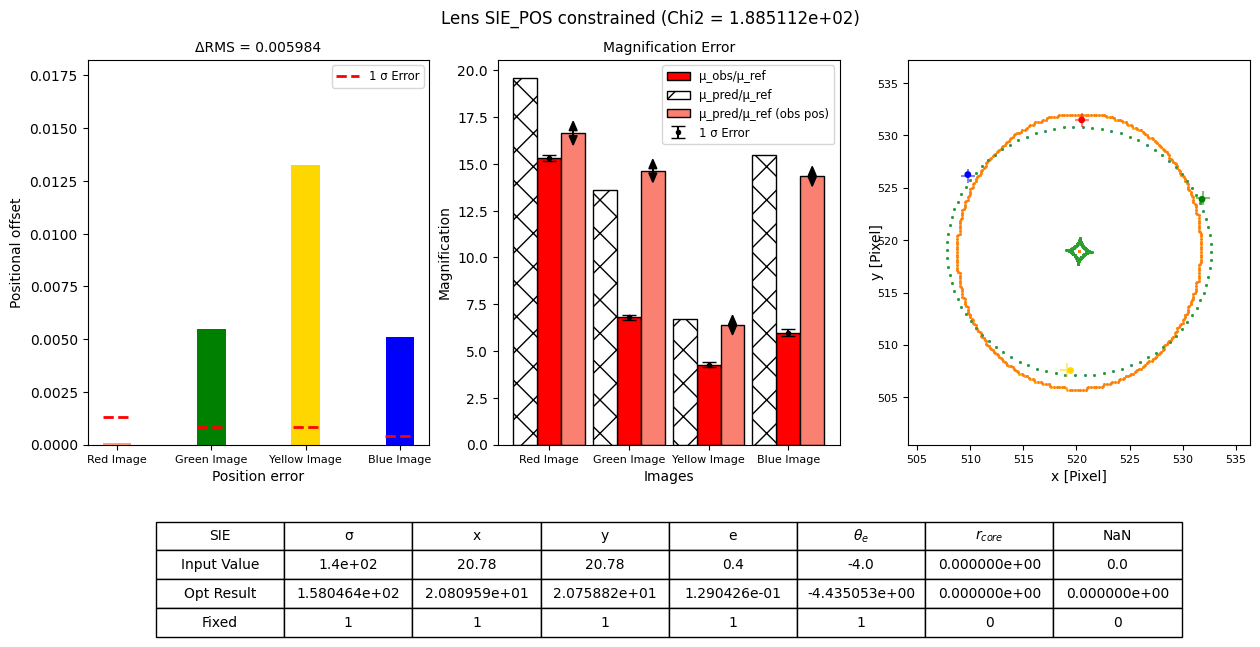

In [96]:
plot_name_1 = 'SIE_POS'
loc = 'SIE/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point_SIE(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [ ]:
%run SIE/pos_flux_point.py

In [ ]:
plot_name_1 = 'SIE_POS+FLUX'
loc = 'SIE/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [ ]:
# POW Lens Model
%run POW/pos_point.py

In [ ]:
plot_name_1 = 'POW_POS'
loc = 'POW/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [ ]:
# POW Lens Model
%run POW/pos_flux_point.py

In [ ]:
plot_name_1 = 'POW_POS+FLUX'
loc = 'POW/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [ ]:
# NFW Lens Model
%run NFW/pos_point.py

In [ ]:
plot_name_1 = 'NFW_POS'
loc = 'NFW/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [ ]:
# NFW Lens Model
%run NFW/pos_flux_point.py

In [ ]:
plot_name_1 = 'NFW_POS+FLUX'
loc = 'NFW/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [ ]:
# Core SIE
%run C_SIE/pos_point.py

In [ ]:
plot_name_1 = 'SIE_POS'
loc = 'C_SIE/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [ ]:
%run C_SIE/pos_flux_point.py

In [ ]:
plot_name_1 = 'SIE_POS+FLUX'
loc = 'C_SIE/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)